# Diferencijabilno programiranje u okviru PyTorch

PyTorch je Python biblioteka koja pruža dvije glavne funkcionalnosti:
* Matrični izračuni s podrškom za GPU izvođenje
* Stvaranje dubokih modela uz automatsku diferencijaciju izračunskog grafa

Glavne značajke okvira:
* Visoka razina integracije s ostalim Python bibliotekama(NumPy, SciPy, Pillow)
* Dinamičko definiranje izračunskih grafova

Korisni linkovi:
* [GitHub repozitorij projekta](https://github.com/pytorch/pytorch)
* [Dokumentacija](https://pytorch.org/docs/stable/index.html)
* [Službeni tutoriali](https://pytorch.org/tutorials/)

![](img/dynamic_graph.gif)

In [50]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose

import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg

from sklearn.metrics import accuracy_score

In [51]:
# CPU/GPU na kojem se rade izračuni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
plt.rcParams["figure.figsize"] = [12, 9]

#### Metode za vizualizaciju podataka

In [53]:
def show_batch(batch, preds=None, class_def=None):
    '''
    Show a batch of images and optional predictions w. or w.o. class names
    :param batch: tuple of (imgs, labels) batch
    :param preds: iterable of predictions for each image in batch
    :param class_def: iterable of class names
    :return:
    '''
    imgs, labels = batch
    N, C, H, W = imgs.shape
    r, c = [int(math.ceil(math.sqrt(N)))] * 2
    if preds is None:
        preds = torch.ones(N).long() * -1

    for i, (im, label, pred) in enumerate(zip(imgs, labels, preds)):
        plt.subplot(r, c, i + 1)
        plt.imshow(im.permute((1, 2, 0)).numpy().squeeze(), cmap='gray' if C == 1 else None)
        title = f'Label: {label.item() if class_def is None else class_def[int(label.item())]}'
        if pred > 0:
            title +=  f' Prediction: {pred.item() if class_def is None else class_def[int(pred.item())]}'
        plt.title(title)
    plt.tight_layout()
    plt.show()


def show_errors(dataset, true, pred, class_def=None):
    '''
    Show misclassified examples
    :param dataset: data container for (image, label) tuples
    :param true: 1D ndarray of GT labels
    :param pred: 1D ndarray of predicted classes
    :param class_def: iterable of class names
    :return:
    '''
    missedd_indices = np.where(pred != true)[0][:16]
    missed_img = torch.stack([dataset[i][0] for i in missedd_indices])
    missed_lab, missed_pred = true[missedd_indices], pred[missedd_indices]
    show_batch((missed_img, missed_lab), preds=missed_pred, class_def=class_def)


def show_fc_params(params, size=(28, 28)):
    '''
    Show fully connected layer parameters slice by slice
    :param params: torch.nn.Parameter
    :param size:
    :return:
    '''
    W = np.copy(params.data.cpu().numpy().transpose())
    r, c = [int(math.ceil(math.sqrt(W.shape[0])))] * 2
    for i, w in enumerate(W):
        w = w.reshape(size) - w.min()
        w /= w.max()
        plt.subplot(r, c, i + 1)
        plt.imshow(w, cmap='gray')
    plt.show()


def show_conv_params(params):
    '''
    Show convolutional layer parameters channel by channel
    :param params: torch.nn.Parameter
    :return: 
    '''
    W = np.copy(params.data.cpu().numpy())
    r, c = [int(math.ceil(math.sqrt(W.shape[0])))] * 2
    for i, w in enumerate(W):
        w -= w.min()
        w /= w.max()
        plt.subplot(r, c, i + 1)
        plt.imshow(w.transpose(1, 2, 0).squeeze())
    plt.show()

In [54]:
def to_tensor(image):
    '''
    Convert Numpy array to Torch tensor
    :param image: 2D/3D ndarray
    :return: Tensor (C, H, W)
    '''
    x = np.float32(image)
    x /= 255
    if len(x.shape) == 2:
        x = np.expand_dims(x, axis=0)
    else:
        x = np.transpose(x, (2, 0, 1))
    return torch.from_numpy(x)

In [55]:
mnist_train = MNIST(os.getcwd(), train=True, transform=to_tensor, download=True)
mnist_test = MNIST(os.getcwd(), train=False, transform=to_tensor, download=True)

In [56]:
dataloader_train = DataLoader(mnist_train, batch_size=16, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
dataloader_test = DataLoader(mnist_test, batch_size=16)

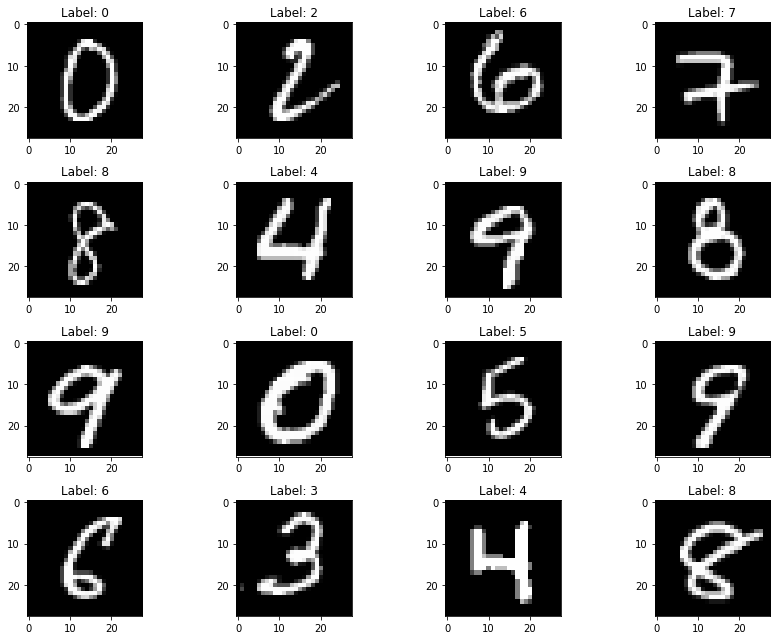

In [57]:
show_batch(next(iter(dataloader_train)))

## Model logističke regresije
$\mathbf{P}(\mathbf{x}) = softmax(\mathbf{x} \mathbf{W} + \mathbf{b})$


In [58]:
class LogRegClassifier(nn.Module):
    def __init__(self, num_features, num_classes, bias=False):
        super(LogRegClassifier, self).__init__()
        self.W = nn.Parameter(data=torch.randn((num_features, num_classes)))
        if bias:
            self.b = nn.Parameter(data=torch.zeros(num_classes))

    def forward(self, input):
        x = input.view(input.size(0), -1)
        s = torch.mm(x, self.W)
        if hasattr(self, 'b'):
            s += self.b
        return s

In [59]:
model = LogRegClassifier(28 ** 2, 10).to(device)

#### Gubitak unakrsne entropije
$
\mathcal{L}(\mathbf{W},\mathbf{b}|\mathcal{D})=\sum_i -\log P(Y=y_i|\mathbf{x}_i)
$

In [60]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1)
criterion = nn.CrossEntropyLoss()

In [80]:
def evaluate(dataloader, size, model):
    with torch.no_grad():
        preds, true = np.zeros((size,), dtype=np.uint8), np.zeros((size,), dtype=np.uint8)
        for step, (x, y) in enumerate(dataloader):
            logits = model(x.to(device))
            _, pred = logits.max(1)
            pred = pred.byte().cpu().numpy()
            t = y.byte().cpu().numpy()
            preds[step * len(pred): (step + 1) * len(pred)] = pred
            true[step * len(pred): (step + 1) * len(pred)] = t
        return accuracy_score(true, preds), true, preds

In [62]:
class Trainer(object):
    def __init__(self, loader_train, loader_test, model, criterion, optimizer, epochs):
        self.loader_train = loader_train
        self.loader_test = loader_test
        self.num_train = len(self.loader_train.dataset)
        self.num_test = len(self.loader_test.dataset)
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

    def train(self):
        for e in range(self.epochs):
            steps = len(dataloader_train)
            for step, (x, y) in enumerate(self.loader_train):
                x, y = x.to(device), y.to(device)
                logits = self.model(x)
                loss = self.criterion(logits, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if step % 1000 == 0:
                    print(f'Epoch {e+1}/{self.epochs} step {step}/{steps} loss: {loss.cpu().item():.2f}')
            acc_train, true_train, preds_train = evaluate(self.loader_train, self.num_train, self.model)
            acc_test, true_test, preds_test = evaluate(self.loader_test, self.num_test, self.model)
            print(f'Accuracy train: {100 * acc_train:.2f}%')
            print(f'Accuracy test: {100 * acc_test:.2f}%')
        return true_test, preds_test

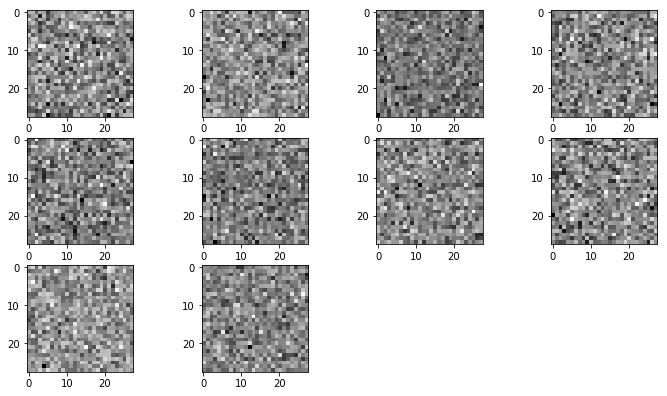

In [63]:
show_fc_params(model.W)

In [64]:
with Trainer(dataloader_train, dataloader_test, model, criterion, optimizer, epochs=5) as trainer:
    true_test, preds_test = trainer.train()

Epoch 1/5 step 0/3750 loss: 16.43
Epoch 1/5 step 1000/3750 loss: 2.14
Epoch 1/5 step 2000/3750 loss: 1.47
Epoch 1/5 step 3000/3750 loss: 0.89
Accuracy train: 85.17%
Accuracy test: 85.87%
Epoch 2/5 step 0/3750 loss: 0.71
Epoch 2/5 step 1000/3750 loss: 0.87
Epoch 2/5 step 2000/3750 loss: 0.83
Epoch 2/5 step 3000/3750 loss: 0.56
Accuracy train: 85.25%
Accuracy test: 85.94%
Epoch 3/5 step 0/3750 loss: 0.95
Epoch 3/5 step 1000/3750 loss: 0.62
Epoch 3/5 step 2000/3750 loss: 0.67
Epoch 3/5 step 3000/3750 loss: 1.00
Accuracy train: 84.97%
Accuracy test: 85.93%
Epoch 4/5 step 0/3750 loss: 0.74
Epoch 4/5 step 1000/3750 loss: 1.13
Epoch 4/5 step 2000/3750 loss: 0.64
Epoch 4/5 step 3000/3750 loss: 0.78
Accuracy train: 85.02%
Accuracy test: 85.58%
Epoch 5/5 step 0/3750 loss: 0.87
Epoch 5/5 step 1000/3750 loss: 1.19
Epoch 5/5 step 2000/3750 loss: 0.72
Epoch 5/5 step 3000/3750 loss: 0.80
Accuracy train: 84.60%
Accuracy test: 85.35%


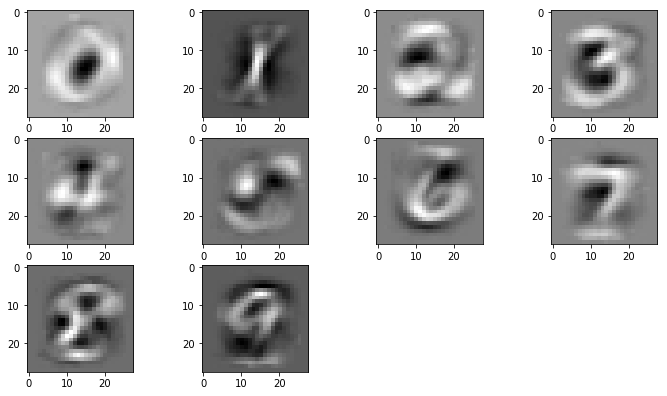

In [65]:
show_fc_params(model.W)

## Duboki konvolucijski model
$conv(16,5) \rightarrow relu() \rightarrow pool(3,2) \rightarrow conv(32,5) \rightarrow relu() \rightarrow pool(3,2) \rightarrow fc(256) \rightarrow relu() \rightarrow fc(128) \rightarrow relu() \rightarrow fc(10)$

![Conv model](img/mozgalo_model.png "Model")

In [66]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConvClassifier(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, input_size=(28, 28)):
        super(ConvClassifier, self).__init__()
        fc_in_h, fc_in_w = self._flat_wh(input_size)
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 16, 5),  # 24x24
            nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2),  # 11x11
            nn.Conv2d(16, 32, 5),  # 7x7
            nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2),  # 3x3
            Flatten(),  # 3*3*32
            nn.Linear(fc_in_h * fc_in_w * 32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def _flat_wh(self, size):
        w, h = size
        return self._fc_in(h), self._fc_in(w)

    def _fc_in(self, x):
        c1 = x - 4
        p1 = (c1 - 3) // 2 + 1
        c2 = p1 - 4
        p2 = (c2 - 3) // 2 + 1
        return p2

    def forward(self, x):
        return self.model(x)

In [67]:
deep_model = ConvClassifier().to(device)

In [68]:
deep_optimizer = optim.Adam(deep_model.parameters(), lr=1e-3, weight_decay=1e-3)

In [69]:
with Trainer(dataloader_train, dataloader_test, deep_model, criterion, deep_optimizer, epochs=5) as trainer:
    true_test, preds_test = trainer.train()

Epoch 1/5 step 0/3750 loss: 2.30
Epoch 1/5 step 1000/3750 loss: 0.10
Epoch 1/5 step 2000/3750 loss: 0.04
Epoch 1/5 step 3000/3750 loss: 0.03
Accuracy train: 97.59%
Accuracy test: 97.82%
Epoch 2/5 step 0/3750 loss: 0.13
Epoch 2/5 step 1000/3750 loss: 0.04
Epoch 2/5 step 2000/3750 loss: 0.01
Epoch 2/5 step 3000/3750 loss: 0.02
Accuracy train: 97.91%
Accuracy test: 98.12%
Epoch 3/5 step 0/3750 loss: 0.01
Epoch 3/5 step 1000/3750 loss: 0.03
Epoch 3/5 step 2000/3750 loss: 0.11
Epoch 3/5 step 3000/3750 loss: 0.02
Accuracy train: 98.36%
Accuracy test: 98.52%
Epoch 4/5 step 0/3750 loss: 0.01
Epoch 4/5 step 1000/3750 loss: 0.00
Epoch 4/5 step 2000/3750 loss: 0.07
Epoch 4/5 step 3000/3750 loss: 0.09
Accuracy train: 98.37%
Accuracy test: 98.36%
Epoch 5/5 step 0/3750 loss: 0.05
Epoch 5/5 step 1000/3750 loss: 0.02
Epoch 5/5 step 2000/3750 loss: 0.01
Epoch 5/5 step 3000/3750 loss: 0.08
Accuracy train: 98.48%
Accuracy test: 98.50%


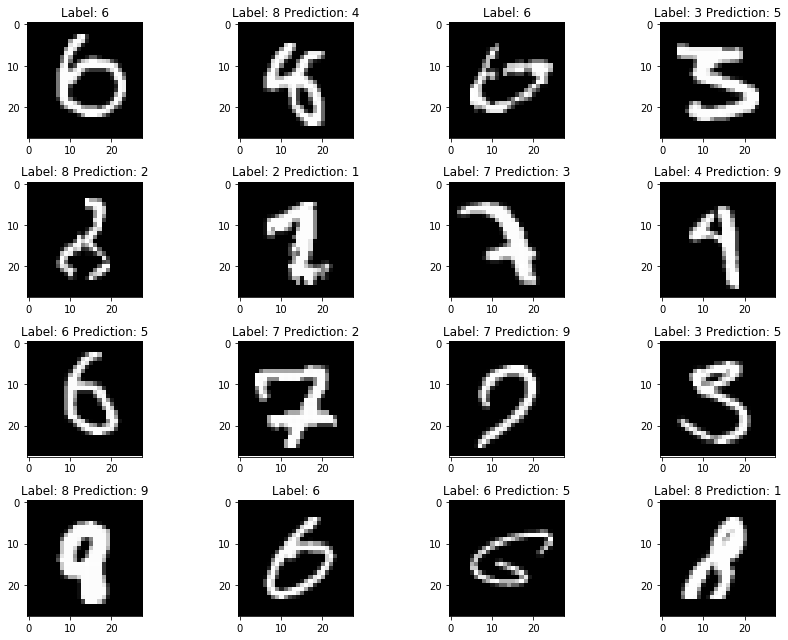

In [70]:
show_errors(mnist_test, true_test, preds_test)

## Klasifikacija na skupu CIFAR10

In [95]:
cifar_model = ConvClassifier(in_channels=3, num_classes=10, input_size=(32, 32)).to(device)

In [96]:
cifar_optimizer = optim.Adam(cifar_model.parameters(), lr=1e-3, weight_decay=1e-4)

##### Rastresanje podataka

In [97]:
def random_flip(image: pimg):
    if np.random.randint(0, 2) == 1:
        return image.transpose(pimg.FLIP_LEFT_RIGHT)
    return image

train_transforms = Compose([random_flip, to_tensor])

In [98]:
cifar_train = CIFAR10(os.getcwd(), train=True, transform=train_transforms, download=True)
cifar_test = CIFAR10(os.getcwd(), train=False, transform=to_tensor, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [99]:
cifar_loader_train = DataLoader(cifar_train, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
cifar_loader_test = DataLoader(cifar_test, batch_size=4)

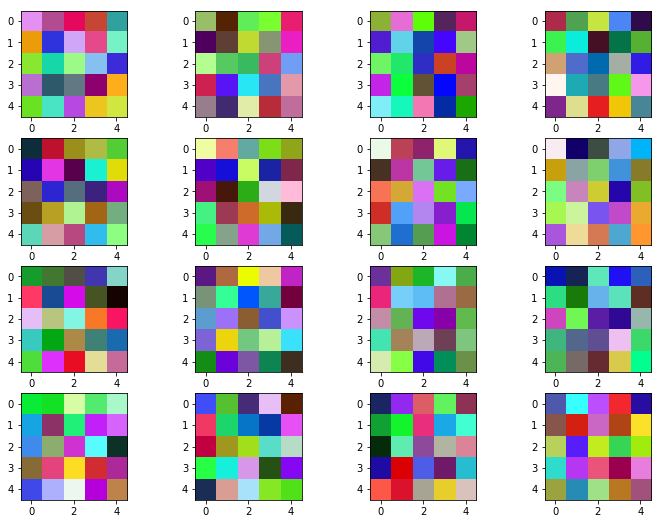

In [100]:
show_conv_params(cifar_model.model[0].weight)

In [101]:
with Trainer(cifar_loader_train, cifar_loader_test, cifar_model, criterion, cifar_optimizer, epochs=10) as trainer:
    true_test, preds_test = trainer.train()

Epoch 1/10 step 0/3750 loss: 2.26
Epoch 1/10 step 1000/3750 loss: 2.01
Epoch 1/10 step 2000/3750 loss: 1.17
Epoch 1/10 step 3000/3750 loss: 1.76
Epoch 1/10 step 4000/3750 loss: 1.12
Epoch 1/10 step 5000/3750 loss: 1.47
Epoch 1/10 step 6000/3750 loss: 2.20
Epoch 1/10 step 7000/3750 loss: 1.48
Epoch 1/10 step 8000/3750 loss: 1.43
Epoch 1/10 step 9000/3750 loss: 1.69
Epoch 1/10 step 10000/3750 loss: 1.62
Epoch 1/10 step 11000/3750 loss: 1.20
Epoch 1/10 step 12000/3750 loss: 0.96
Accuracy train: 50.33%
Accuracy test: 49.08%
Epoch 2/10 step 0/3750 loss: 1.94
Epoch 2/10 step 1000/3750 loss: 1.35
Epoch 2/10 step 2000/3750 loss: 0.95
Epoch 2/10 step 3000/3750 loss: 0.91
Epoch 2/10 step 4000/3750 loss: 1.60
Epoch 2/10 step 5000/3750 loss: 1.64
Epoch 2/10 step 6000/3750 loss: 1.13
Epoch 2/10 step 7000/3750 loss: 0.81
Epoch 2/10 step 8000/3750 loss: 1.86
Epoch 2/10 step 9000/3750 loss: 1.47
Epoch 2/10 step 10000/3750 loss: 1.42
Epoch 2/10 step 11000/3750 loss: 0.88
Epoch 2/10 step 12000/3750 loss

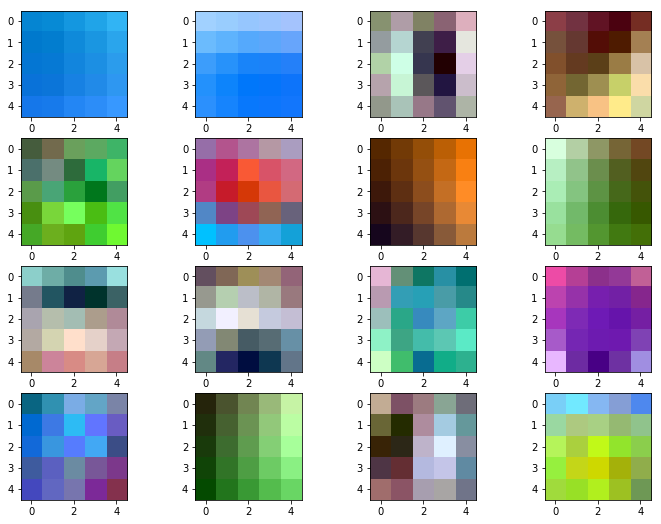

In [102]:
show_conv_params(cifar_model.model[0].weight)

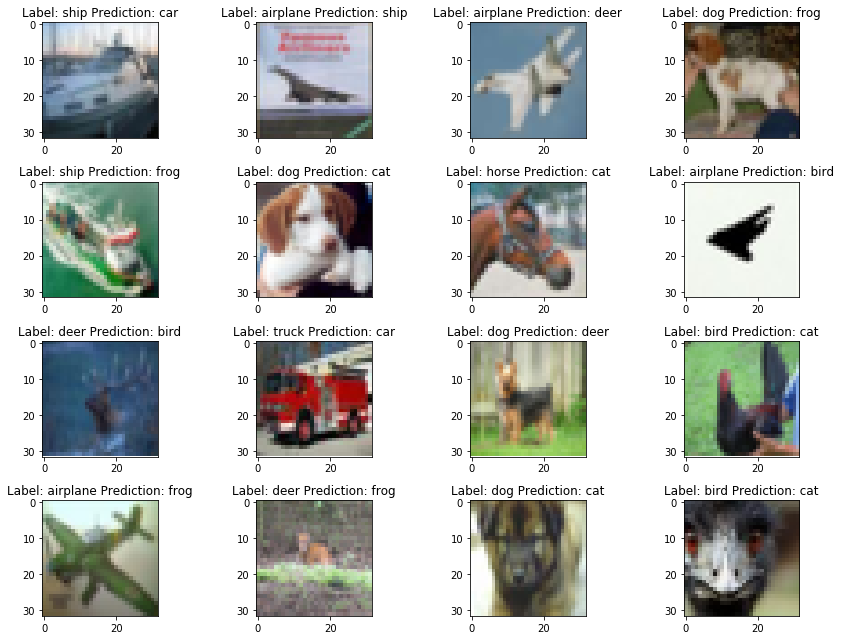

In [103]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_errors(cifar_test, true_test, preds_test, class_def=classes)